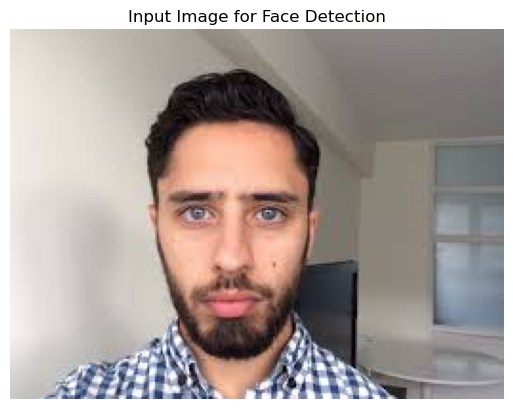

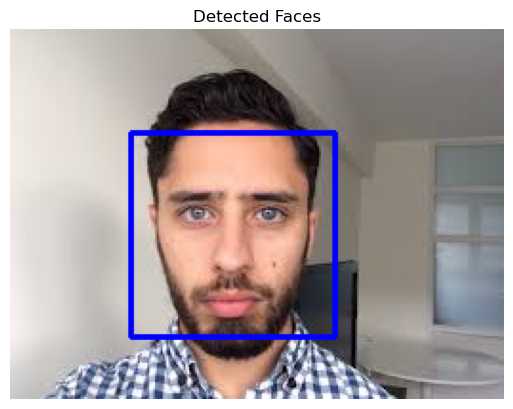

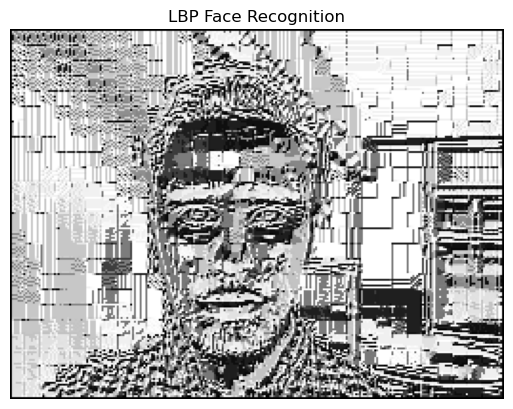

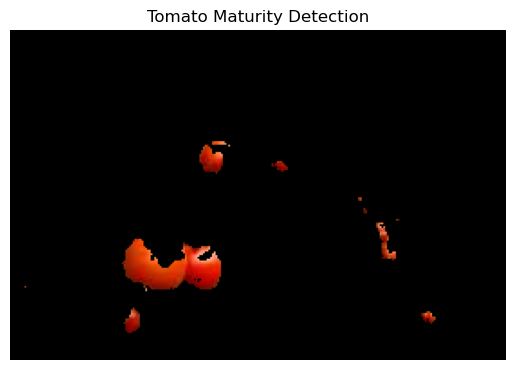

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def viola_jones_face_detection(image_path):
    image = cv2.imread(image_path)
    display_image(image, "Input Image for Face Detection")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    display_image(image, "Detected Faces")
    return image

def yolo_object_detection(image_path, yolo_weights, yolo_cfg, yolo_names):
    image = cv2.imread(image_path)
    display_image(image, "Input Image for YOLO Object Detection")
    net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
    layer_names = net.getUnconnectedOutLayersNames()
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)
    
    height, width = image.shape[:2]
    boxes, confidences, class_ids = [], [], []
    
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    with open(yolo_names, "r") as f:
        classes = f.read().strip().split("\n")
    
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        color = (0, 255, 0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    display_image(image, "YOLO Object Detection")
    return image

def lucas_kanade_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    mask = np.zeros_like(old_frame)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
            frame = cv2.circle(frame, (a, b), 5, (0, 0, 255), -1)
        img = cv2.add(frame, mask)
        cv2.imshow('Optical Flow', img)
        if cv2.waitKey(30) & 0xFF == 27:
            break
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    cap.release()
    cv2.destroyAllWindows()


def compute_lbp(image):
    """Compute Local Binary Pattern of an image."""
    lbp = np.zeros_like(image)
    rows, cols = image.shape
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            center = image[i, j]
            binary_string = ''
            binary_string += '1' if image[i-1, j-1] >= center else '0'
            binary_string += '1' if image[i-1, j] >= center else '0'
            binary_string += '1' if image[i-1, j+1] >= center else '0'
            binary_string += '1' if image[i, j+1] >= center else '0'
            binary_string += '1' if image[i+1, j+1] >= center else '0'
            binary_string += '1' if image[i+1, j] >= center else '0'
            binary_string += '1' if image[i+1, j-1] >= center else '0'
            binary_string += '1' if image[i, j-1] >= center else '0'
            lbp[i, j] = int(binary_string, 2)
    
    return lbp

def lbp_face_recognition(image_path):
    """Perform face recognition using LBP manually."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print("Error: Image not found!")
        return
    
    lbp_image = compute_lbp(image)
    display_image(lbp_image, "LBP Face Recognition")
    return lbp_image

def tomato_maturity_detection(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    result = cv2.bitwise_and(image, image, mask=mask)
    display_image(result, "Tomato Maturity Detection")
    return result

# Example Calls
viola_jones_face_detection(r"C:\Users\New\Downloads\face.jpeg")
#yolo_object_detection("path/to/your/image.jpg", "path/to/yolov3.weights", "path/to/yolov3.cfg", "path/to/coco.names")
#lucas_kanade_optical_flow("path/to/your/video.mp4")
lbp_face_recognition(r"C:\Users\New\Downloads\face.jpeg")
tomato_maturity_detection(r"C:\Users\New\Downloads\tomato.jpeg")


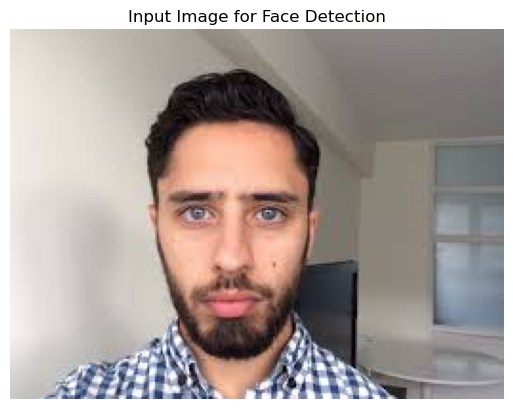

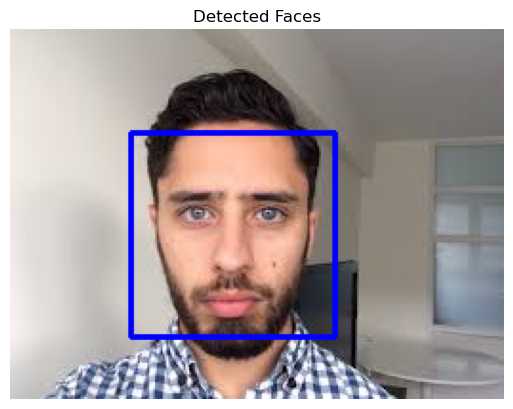

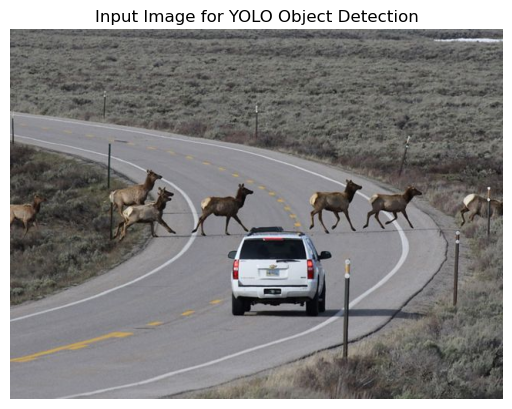

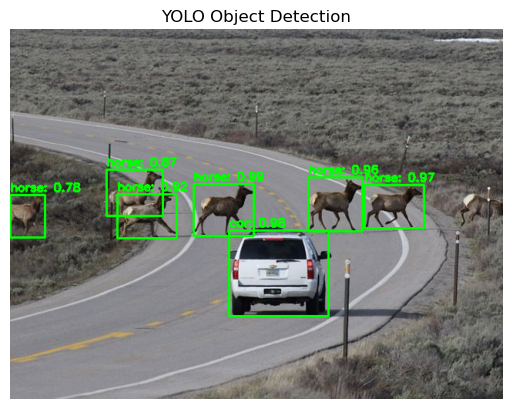

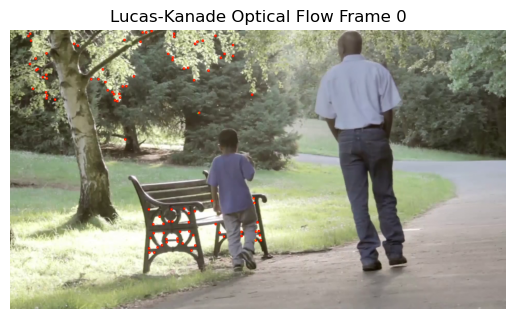

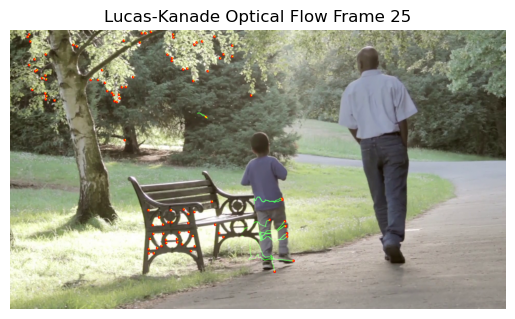

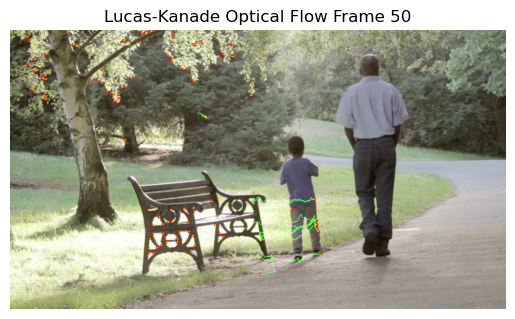

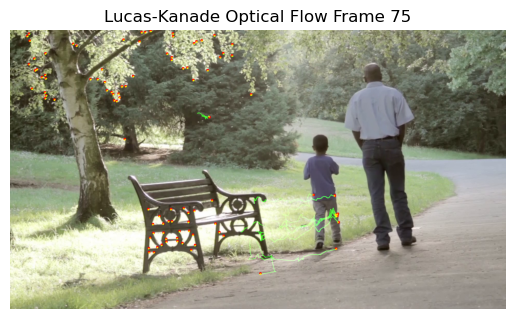

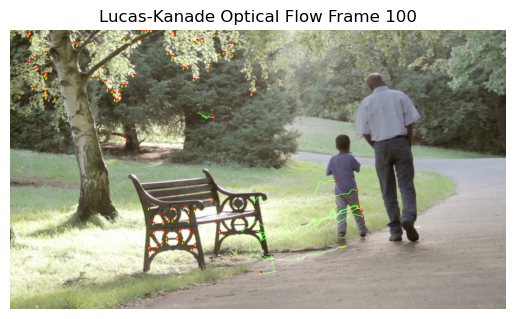

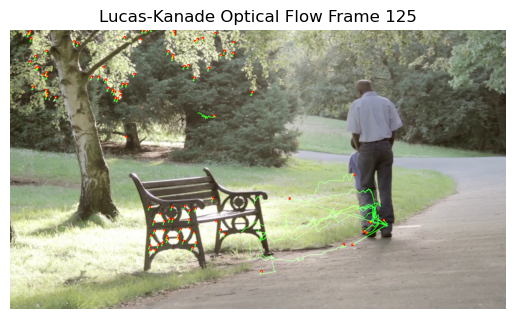

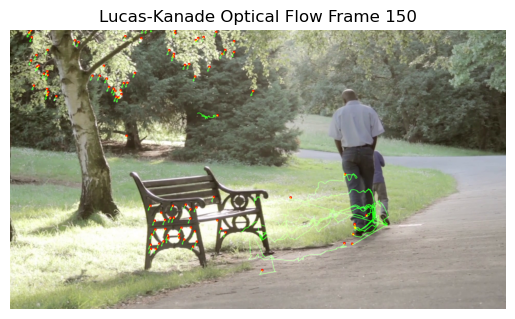

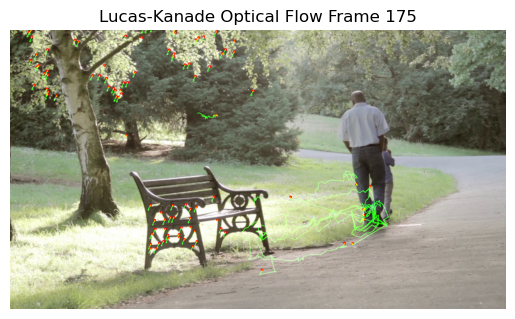

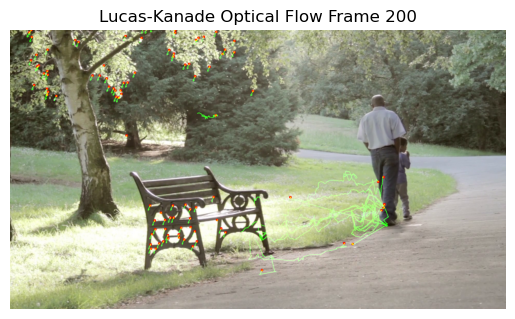

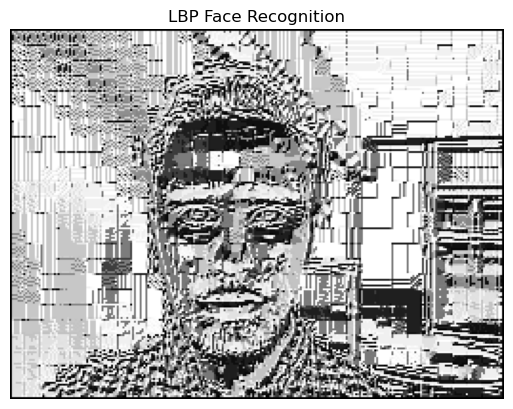

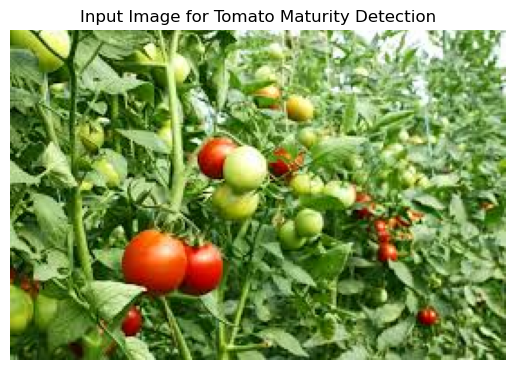

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def viola_jones_face_detection(image_path):
    image = cv2.imread(image_path)
    display_image(image, "Input Image for Face Detection")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    display_image(image, "Detected Faces")
    return image

def yolo_object_detection(image_path, yolo_weights, yolo_cfg, yolo_names):
    image = cv2.imread(image_path)
    display_image(image, "Input Image for YOLO Object Detection")
    net = cv2.dnn.readNet(yolo_weights, yolo_cfg)
    layer_names = net.getUnconnectedOutLayersNames()
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(layer_names)
    
    height, width = image.shape[:2]
    boxes, confidences, class_ids = [], [], []
    
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    with open(yolo_names, "r") as f:
        classes = f.read().strip().split("\n")
    
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        color = (0, 255, 0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    display_image(image, "YOLO Object Detection")
    return image

def lucas_kanade_optical_flow(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    mask = np.zeros_like(old_frame)
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)
        img = cv2.add(frame, mask)
        
        if frame_count % 25 == 0:
            display_image(img, f"Lucas-Kanade Optical Flow Frame {frame_count}")
        
        frame_count += 1
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    cap.release()
    cv2.destroyAllWindows()

def compute_lbp(image):
    lbp = np.zeros_like(image)
    rows, cols = image.shape
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            center = image[i, j]
            binary_string = ''.join(['1' if image[i + di, j + dj] >= center else '0' for di, dj in [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]])
            lbp[i, j] = int(binary_string, 2)
    
    return lbp

def lbp_face_recognition(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    lbp_image = compute_lbp(image)
    display_image(lbp_image, "LBP Face Recognition")
    return lbp_image

def tomato_maturity_detection(image_path):
    image = cv2.imread(image_path)
    display_image(image, "Input Image for Tomato Maturity Detection")
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    result = cv2.bitwise_and(image, image, mask=mask)
    display_image(result, "Tomato Maturity Detection")
    return result

viola_jones_face_detection(r"C:\Users\New\Downloads\face.jpeg")
yolo_object_detection(r"C:\Users\New\Downloads\object detection.jpg", r"C:\Users\New\Downloads\yolov3.weights", r"C:\Users\New\Downloads\yolov3.cfg", r"C:\Users\New\Downloads\coco.names")
lucas_kanade_optical_flow(r"C:\Users\New\Downloads\1721277-hd_1920_1080_25fps.mp4")
lbp_face_recognition(r"C:\Users\New\Downloads\face.jpeg")
tomato_maturity_detection(r"C:\Users\New\Downloads\tomato.jpeg")
